In [33]:
### Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro, norm
import statsmodels.api as sm
import html
from IPython.display import display, HTML
from pathlib import Path
import json

## Data Analysis

This notebook analyzes evaluation results comparing AI-generated chart interpretations under two conditions:

1. **Image only**: o4-mini receives chart without context
2. **Image + context**: o4-mini receives chart with surrounding textual context

Each interpretation was evaluated on four quality dimensions using 7-point Likert scales:
- Accuracy
- Clarity  
- Relevance
- Completeness

Plus an overall preference rating.

### Research Questions

1. Do context-enhanced interpretations score higher on quality dimensions?
2. Which condition do evaluators prefer overall?
3. How do the quality dimensions correlate with each other?

#### Token Usage Descriptives


In [3]:
### --- Descriptive Statistics for Responses ---
# Helper function to load response JSON files into a DataFrame
def load_response_jsons(path, recursive=False):
    path = Path(path)
    pattern = "**/*.json" if recursive else "*.json"
    rows = []
    for fp in path.glob(pattern):
        if not fp.is_file():
            continue
        try:
            with open(fp, "r", encoding="utf-8") as f:
                data = json.load(f)
            usage = (data.get("usage") or {})
            rows.append({
                "timestamp": data.get("timestamp"),
                "item_id": data.get("item_id"),
                "has_context": data.get("has_context"),
                "created_at": data.get("created_at"),
                "output_text": data.get("output_text"),
                "input_tokens": usage.get("input_tokens"),
                "output_tokens": usage.get("output_tokens"),
                "reasoning_tokens": usage.get("reasoning_tokens"),
                "total_tokens": usage.get("total_tokens"),
            })
        except Exception as e:
            print(f"Error reading {fp}: {e}")
    df = pd.DataFrame(rows)

    return df

# Load response JSON files into a DataFrame
responses_df = load_response_jsons("data/responses", recursive=False)

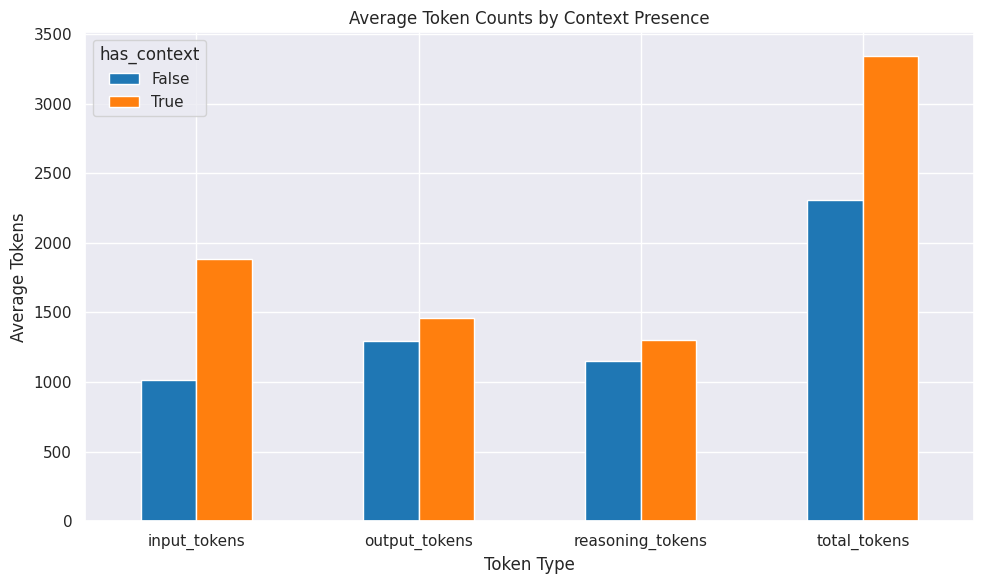

Average Token Counts by Context Presence: 

              input_tokens  output_tokens  reasoning_tokens  total_tokens  \
has_context                                                                
False             1013.51        1297.49           1154.10       2311.00   
True              1887.41        1459.15           1304.13       3346.56   

             input_tokens_std  output_tokens_std  reasoning_tokens_std  \
has_context                                                              
False                  546.55             689.66                688.41   
True                  1244.59             710.71                709.33   

             total_tokens_std  
has_context                    
False                  889.68  
True                  1364.37  


In [14]:
tokens = ["input_tokens", "output_tokens", "reasoning_tokens", "total_tokens"]

# Visualizing average token counts by context presence
sns.set_theme(palette="colorblind")

responses_df.groupby("has_context")[tokens].mean().T.plot.bar(
    figsize=(10, 6),
    title="Average Token Counts by Context Presence",
    ylabel="Average Tokens",
    xlabel="Token Type",
    rot=0,
    color=["#1f77b4", "#ff7f0e"],
    legend=["Without Context", "With Context"]
)
plt.tight_layout()
plt.show()

# Calculate and display mean and standard deviation token counts by context presence
avg_tokens = responses_df.groupby("has_context")[tokens].mean()
avg_tokens_std = responses_df.groupby("has_context")[tokens].std()
avg_tokens = avg_tokens.join(avg_tokens_std, rsuffix="_std")
print(f"Average Token Counts by Context Presence: \n\n {avg_tokens.round(2)}")

###  1. Dataset Loading & Preparation

In [46]:
### --- Reading the data ---
df_raw = pd.read_csv('data/evaluation_results.csv')

### --- Restructuring the DataFrame to long format ---
metrics = ['accuracy', "clarity", "relevance", "completeness"]
conditions = ["with_context", "without_context"]

# Converting the dataset to long format
long_rows = []
for _, row in df_raw.iterrows():
    for cond in conditions:
        long_rows.append({
            "item_index": row.item_index,
            "condition": cond,
            **{m: row[f"{cond}_{m}"] for m in metrics},
            "overall": sum(row[f"{cond}_{m}"] for m in metrics)/len(metrics),
            "preference": row.preference_actual
        })

# Save the long format DataFrame
df = pd.DataFrame(long_rows)

# Creating a label mapping for conditions and better plotting
label_map = {
    "with_context": "Image & Context",
    "without_context": "Image-only",
}
df["condition_label"] = df["condition"].map(label_map)

### 2. Addressing Research Questions

#### 2.1 Do context-enhanced interpretations score higher on quality dimensions?

To answer this question, a paired statistical tests (e.g., paired t-test or Wilcoxon signed-rank if non-normal) on per-item differences was conducted to assess whether context yields significant improvements.

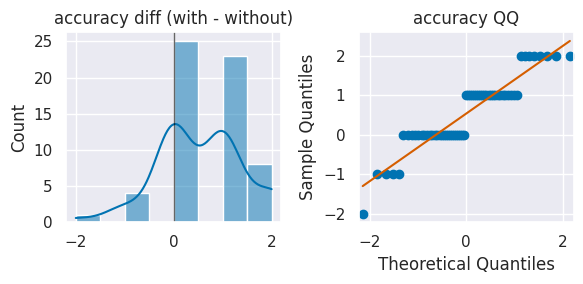

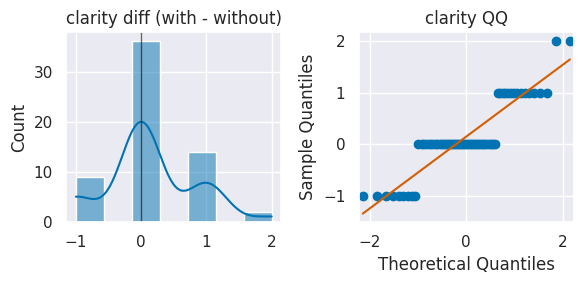

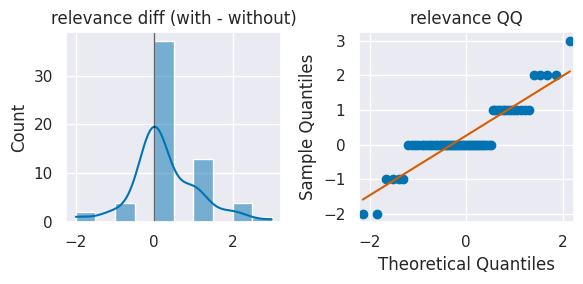

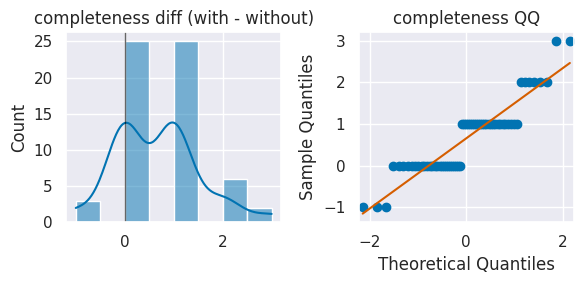

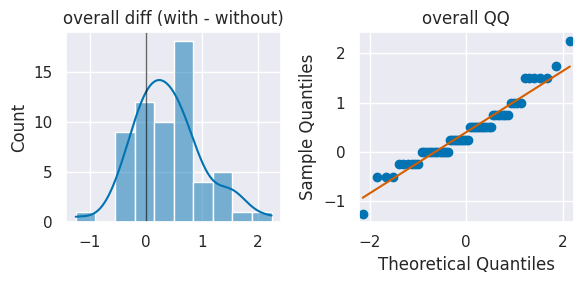

         metric  n_pairs  mean_diff  std_diff  shapiro_p_rounded
0      accuracy       61   0.540984  0.867444            0.00002
1       clarity       61   0.147541  0.703232            0.00000
2     relevance       61   0.262295  0.873721            0.00000
3  completeness       61   0.655738  0.854113            0.00001
4       overall       61   0.401639  0.626296            0.02332


In [15]:
### --- Plotting the distribution of differences & QQ plot ---
q_dims = metrics + ["overall"]

shapiro_rows = []
for q in q_dims:
    wide_q = df.pivot(index="item_index", columns="condition", values=q)
    diff = wide_q["with_context"] - wide_q["without_context"]
    diff_clean = diff.dropna()
    
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    sns.histplot(diff_clean, kde=True, ax=axes[0])
    axes[0].set_title(f"{q} diff (with - without)")
    axes[0].axvline(0, color="black", lw=1, alpha=0.6)
    sm.qqplot(diff_clean, line="s", ax=axes[1])
    axes[1].set_title(f"{q} QQ")
    plt.tight_layout()
    plt.show()
    
    # Shapiro test (needs at least 3 values; meaningful if n >= 8)
    if len(diff_clean) >= 3:
        p = shapiro(diff_clean).pvalue
    else:
        p = np.nan
    shapiro_rows.append({
        "metric": q,
        "n_pairs": len(diff_clean),
        "mean_diff": diff_clean.mean(),
        "std_diff": diff_clean.std(ddof=1),
        "shapiro_p": p
    })

shapiro_df = pd.DataFrame(shapiro_rows)
shapiro_df["shapiro_p_rounded"] = shapiro_df["shapiro_p"].round(5)
print(shapiro_df[["metric","n_pairs","mean_diff","std_diff","shapiro_p_rounded"]])

Inspecting the distribution of differences histograms and the QQ plots, it is apparent that we are dealing with non-normally distributed data. This is also supported by the results from Shapiro-Wilk test which indicate strong-moderate evidence of non-normality. Therefore, non-parametric test is required to evaluate whether the two conditions differ on the quality of the chart interpretations.

In [42]:
### --- Statistical Tests for Differences in Quality Dimensions ---

# Performing Wilcoxon signed-rank test for each quality dimension + overall
rows = []
for q in q_dims:
    w = df.pivot(index="item_index", columns="condition", values=q)[["without_context","with_context"]]
    if w.empty: 
        continue
    diff = w["with_context"] - w["without_context"]

    # Wilcoxon signed-rank test (two-sided)
    w_stat, p_w = wilcoxon(diff)

    # Effect sizes
    pos = (diff > 0).sum()
    neg = (diff < 0).sum()
    n_eff = pos + neg
    r_rb = (pos - neg) / n_eff if n_eff else float("nan")  # rank-biserial
    # r from z (signed by mean diff), using normal approx from two-sided p
    z = norm.isf(p_w / 2.0) if p_w > 0 else float("inf")
    r_from_z = (z * (1 if diff.mean() >= 0 else -1)) / (n_eff ** 0.5) if n_eff else float("nan")

    # Quartiles and display ranges [Q1, Q3] - computed on the same paired subset
    q1_w, q3_w = w["with_context"].quantile([0.25, 0.75])
    q1_wo, q3_wo = w["without_context"].quantile([0.25, 0.75])
    q1_d, q3_d = diff.quantile([0.25, 0.75])

    rows.append({
        "metric": q,
        "n": len(w),
        "mean_with": w["with_context"].mean(),
        "mean_without": w["without_context"].mean(),
        "mean_diff": diff.mean(),
        "median_with": w["with_context"].median(),
        "median_without": w["without_context"].median(),
        "median_diff": diff.median(),
        "with_Q1_Q3": f"[{q1_w:.2f}, {q3_w:.2f}]",
        "without_Q1_Q3": f"[{q1_wo:.2f}, {q3_wo:.2f}]",
        "diff_Q1_Q3": f"[{q1_d:.2f}, {q3_d:.2f}]",
        "w_stat": w_stat,
        "wilcoxon_p": p_w,
        "rank_biserial": r_rb,
        "r_from_z": r_from_z,
    })

stats_df = pd.DataFrame(rows).round({
    "mean_with":3, "mean_without":3, "mean_diff":3,
    "median_with":3, "median_without":3, "median_diff":3,
    "w_stat":3, "wilcoxon_p":4, "rank_biserial":3, "r_from_z":3
})

print(stats_df)

         metric   n  mean_with  mean_without  mean_diff  median_with  \
0      accuracy  61      6.590         6.049      0.541         7.00   
1       clarity  61      6.623         6.475      0.148         7.00   
2     relevance  61      6.820         6.557      0.262         7.00   
3  completeness  61      6.803         6.148      0.656         7.00   
4       overall  61      6.709         6.307      0.402         6.75   

   median_without  median_diff    with_Q1_Q3 without_Q1_Q3    diff_Q1_Q3  \
0             6.0         1.00  [6.00, 7.00]  [5.00, 7.00]  [0.00, 1.00]   
1             7.0         0.00  [6.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
2             7.0         0.00  [7.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
3             6.0         1.00  [7.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
4             6.5         0.25  [6.50, 7.00]  [6.00, 6.75]  [0.00, 0.75]   

   w_stat  wilcoxon_p  rank_biserial  r_from_z  
0    88.0      0.0000          0.722     0.678  
1   108.0   

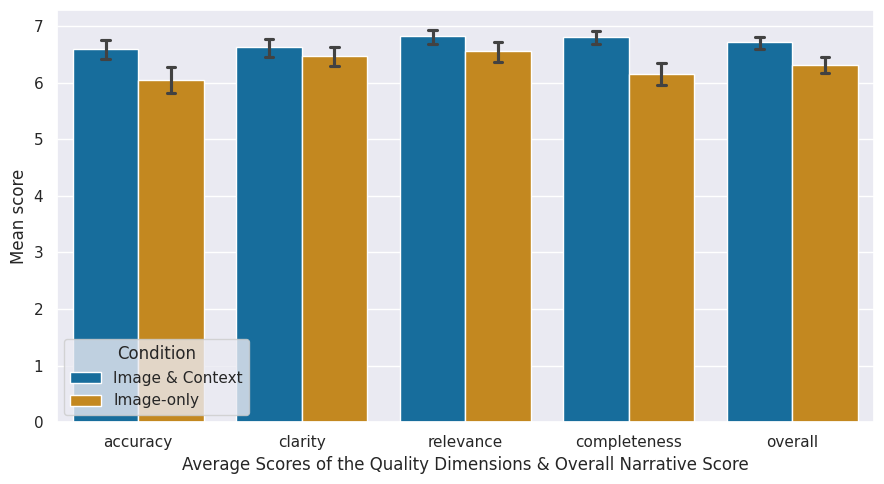

In [49]:
### --- Visualizing the Quality Dimensions mean scores ---

mean_long = df.melt(id_vars=["condition_label"], value_vars=q_dims,
                    var_name="q_dims", value_name="score")

plt.figure(figsize=(9,5))
sns.barplot(data=mean_long, x="q_dims", y="score", hue="condition_label", errorbar=('ci', 95), capsize=.1)
plt.ylabel("Mean score")
plt.xlabel("Average Scores of the Quality Dimensions & Overall Narrative Score")
plt.legend(title="Condition", loc='lower left')
plt.tight_layout()

### 2.2 Investigating overall preference between conditions


Chart Interpretations generated with context were preferred 45 times.

Chart Interpretations generated without context were preferred 8 times.

Chart Interpretations were preferred equally 8 times.


/tmp/ipykernel_805/495899749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preference_df["preference"] = preference_df["preference"].replace({


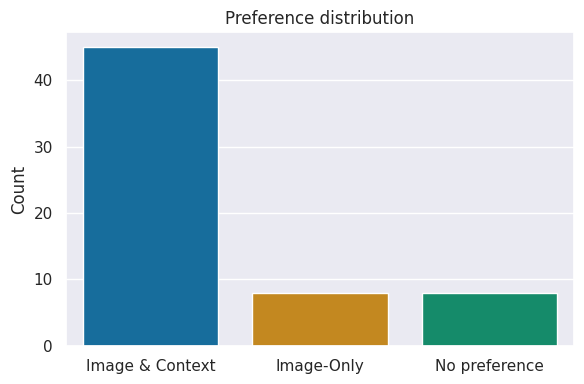

In [40]:
### --- Visualizing the Preference Distribution ---
preference_df = df.drop_duplicates("item_index")
counts = preference_df['preference'].value_counts()

preference_df["preference"] = preference_df["preference"].replace({
    "with_context": "Image & Context",
    "without_context": "Image-Only",
    "equal": "No preference"
})


plt.figure(figsize=(6,4))
sns.countplot(data=preference_df, x="preference",
              order=["Image & Context","Image-Only","No preference"], hue="preference")
plt.xlabel("")
plt.ylabel("Count")
plt.title("Preference distribution")
plt.tight_layout()

print(f"\nChart Interpretations generated with context were preferred {counts.get('with_context', 0)} times.")
print(f"\nChart Interpretations generated without context were preferred {counts.get('without_context', 0)} times.")
print(f"\nChart Interpretations were preferred equally {counts.get('equal', 0)} times.")

### 2.3 Quality Dimensions Correlations

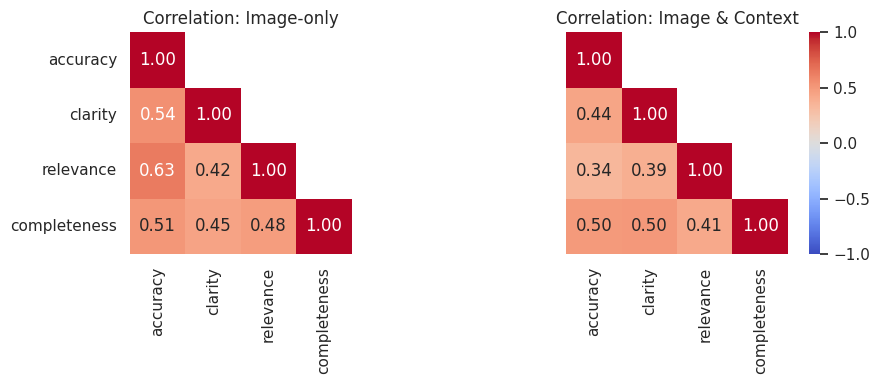

In [51]:
### --- Visualizing the Correlation Matrix ---
# Plotting the correlation matrix for each condition
conds = ["without_context","with_context"]

with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
    for ax, cond in zip(axes, conds):
        sub = df[df["condition"] == cond][metrics]
        corr = sub.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
        sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="coolwarm",
                    annot=True, fmt=".2f", square=True, cbar=(cond=="with_context"), ax=ax)
        ax.set_title(f"Correlation: {label_map[cond]}")
    plt.tight_layout()

### 3. Error Analysis

This section will outline the common and uncommon errors that the model made across the two conditions.

Simple charts were interpreted quite well even without the context (items 6, 12, 33)

Common errors in no context condition:

- Lacking contextual grounding
- Lacking detail
- Misinterpreting domain-specific terms

Common errors in context condition:
- Adding informative detail, however, underivable from the chart image (e.g., items 7, 23, 30)


Other items to possibly note 
- 1 (both didn't mention an aspect of the chart); 
- 7, 23, 30 (example of refraining the interpretation to the chart only, where as other description adds more information not derivable from the chart itself);
- 48 (making different claims about the chart);
- 50, 52, 56 (big difference between scores, no context condition much worse + ???).

NB (7, 23, 30 - include e.gs., of no context refraining the interpretation to the chart only)
    

In [66]:
### --- Loading the Images & Responses ---
# Helper functions
img_df = pd.read_csv('data/evaluation_ready.csv')
good_interpretations = [5, 11, 32]
contextual_grounding = [10, 13, 15]
extra_detail = [6, 22, 29, 45]
false_claims = [12, 47, 58]
large_differences = [51, 55]
omissions = [0, 31]

items = good_interpretations + extra_detail + false_claims + large_differences + omissions + contextual_grounding
items.sort()

def show_card(row, img_width=420):
    def esc(x): return html.escape("" if pd.isna(x) else str(x))
    display(HTML(f"""
    <div style="display:grid; grid-template-columns: {img_width}px 1fr 1fr; gap:12px; margin:10px 0; padding:12px; border:1px solid #e5e7eb; border-radius:8px; font-family:system-ui, sans-serif;">
      <div><img src="{esc(row['image_path_1'])}" style="max-width:100%; height:auto; border:1px solid #eee;"/></div>
      <div><div style="font-weight:600; margin-bottom:6px;">With context</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['with_context'])}</div></div>
      <div><div style="font-weight:600; margin-bottom:6px;">Without context</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['without_context'])}</div></div>
    </div>
    """))

#### Examples of good interpretations across both conditions

In [60]:
### --- Good Interpretations in Both Conditions ---
for _, r in img_df.loc[good_interpretations].iterrows():
    show_card(r)

#### Examples of Interpretations having extra detail from context

In [68]:
### --- Chart & Chart interpretations that include extra detail underivable from the context ---
for _, r in img_df.loc[extra_detail].iterrows():
    show_card(r)

In [69]:
### --- Chart & Chart interpretations where the some claims are wrong ---
for _, r in img_df.loc[false_claims].iterrows():
    show_card(r)

In [70]:
### --- Chart & Chart interpretations that had a large difference in scores between conditions ---
for _, r in img_df.loc[large_differences].iterrows():
    show_card(r)

In [71]:
### --- Chart & Chart interpretations where crucial information was ommitted ---
for _, r in img_df.loc[omissions].iterrows():
    show_card(r)

In [72]:
### --- Chart & Chart interpretations where a clear contextual grounding is present ---
for _, r in img_df.loc[contextual_grounding].iterrows():
    show_card(r)